In [1]:
import numpy as np                        # Math
import scipy.stats                        # Statistics
from matplotlib import pyplot as plt      # Plots

Read the npy file

In [2]:
input_file_path = '/Users/giulia/coding/astrostat/astrostatistics_bicocca_2024/solutions/transient.npy'
data = np.load(input_file_path)

#print(data)

This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

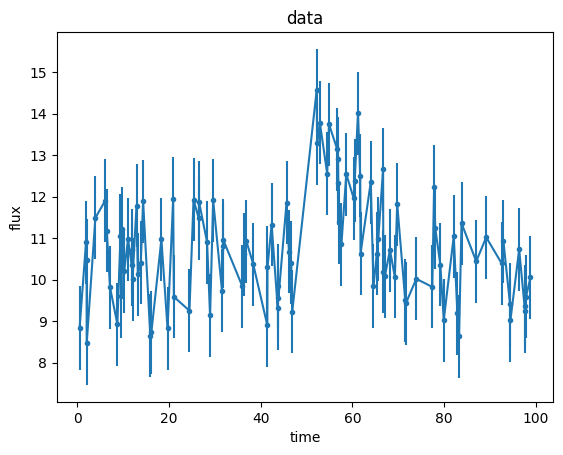

In [3]:
t,y,yerr=data.T

plt.errorbar(t,y,yerr=yerr, marker = '.')
plt.xlabel('time')
plt.ylabel('flux')
plt.title('data')

plt.show()

# emcee

Using the tutorial: https://emcee.readthedocs.io/en/stable/tutorials/line/

### Setup

The model

In [4]:
def burst_model (x, theta):
    A,b,t0,alpha=theta
    return np.where(x<t0,b,b+A*np.exp(-alpha*(x-t0)))

The log likelihood

In [5]:
def LogLikelihood(theta, data, model):
    x, y, sigma_y = data.T
    y_fit = model(x, theta)
    return -0.5 * np.sum((y-y_fit)**2 / sigma_y**2 ) 

The log prior

In [6]:
Amin, Amax = 0, 50
bmin, bmax = 0, 50
t0min, t0max = 0, 100
alphamin, alphamax = np.exp(-5), np.exp(5)

def Logprior(theta):
    A,b,t0,alpha=theta
    if Amin < A < Amax and bmin < b < bmax and t0min < t0 < t0max and alphamin < alpha < alphamax:
        return - np.log(alpha)    # 0.0 + 0.0 + 0.0 - np.log(alpha) --> since uniform in log alpha, so p(alpha) = 1/alpha
    return -np.inf
    

The log posterior

In [7]:
def LogPosterior(theta, data, model):
    return LogLikelihood(theta, data, model) + Logprior(theta)

### Estimate the initial parameters using the maximum likelihood estimation

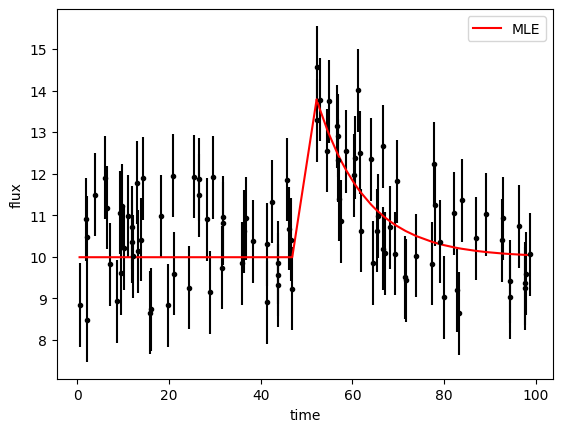

Maximum likelihood estimates:
A = 5.046
b = 9.986
t0 = 49.133
alpha = 0.093


In [8]:
from scipy.optimize import minimize

A_0=5
b_0=10
t0_0=49
alpha_0=0.029

np.random.seed(42)
nll = lambda *args: -LogLikelihood(*args)
initial = np.array([A_0, b_0, t0_0, np.log(alpha_0)]) + 0.1 * np.random.randn(4)
soln = minimize(nll, initial, args=(data, burst_model))
A_ml, b_ml, t0_ml, log_alpha_ml = soln.x

theta_ml = [A_ml, b_ml, t0_ml, np.exp(log_alpha_ml)]

plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(t, burst_model(t, theta_ml), 'red', label = 'MLE')
plt.xlabel("time")
plt.ylabel("flux")

plt.legend()
plt.show()

print("Maximum likelihood estimates:")
print("A = {0:.3f}".format(A_ml))
print("b = {0:.3f}".format(b_ml))
print("t0 = {0:.3f}".format(t0_ml))
print("alpha = {0:.3f}".format(np.exp(log_alpha_ml)))

### MCMC (emcee)

In [9]:
import emcee

ndim = 4             # number of parameters in the model
nwalkers = 20        # number of MCMC walkers
nsteps = 10000       # number of MCMC steps to take **for each walker**

starting_guesses = theta_ml + 1e-1 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, args=[data, burst_model])
sampler.run_mcmc(starting_guesses, nsteps, progress=True)

  0%|                                                                                                                | 0/10000 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2044.95it/s]


State([[ 5.05530684 10.40826003 48.12358743  0.11191234]
 [ 6.92273907 10.30746601 46.87559277  0.13720211]
 [ 4.1559651  10.34867582 50.09563958  0.10663617]
 [ 3.34157723 10.4161486  52.10294696  0.10631718]
 [ 5.39868366 10.30550508 49.8170668   0.11197468]
 [12.95755238 10.38398138 47.22637438  0.21998355]
 [ 5.42552741 10.39231276 50.45498327  0.14168323]
 [ 3.93664643 10.26608372 51.87665657  0.12460414]
 [ 4.60800204 10.06623254 49.54037058  0.09495347]
 [ 4.48090542 10.23672128 52.0980938   0.1225748 ]
 [ 6.83374427 10.31497289 49.0413954   0.17565231]
 [ 5.38935744 10.34726465 49.54390902  0.11516091]
 [ 4.00472664 10.12746815 51.05933877  0.08729386]
 [ 6.46456328 10.03153268 47.49978788  0.10145779]
 [ 6.91200274 10.13067282 48.91348854  0.11875974]
 [ 8.46904993 10.19984222 47.87331255  0.15989682]
 [ 3.59712333 10.27052054 50.38064454  0.09232213]
 [ 4.16083149 10.38785899 51.56804619  0.11987313]
 [ 9.75433768 10.37575624 48.57891662  0.21058237]
 [ 3.89044744 10.18007119

Visualize the chains

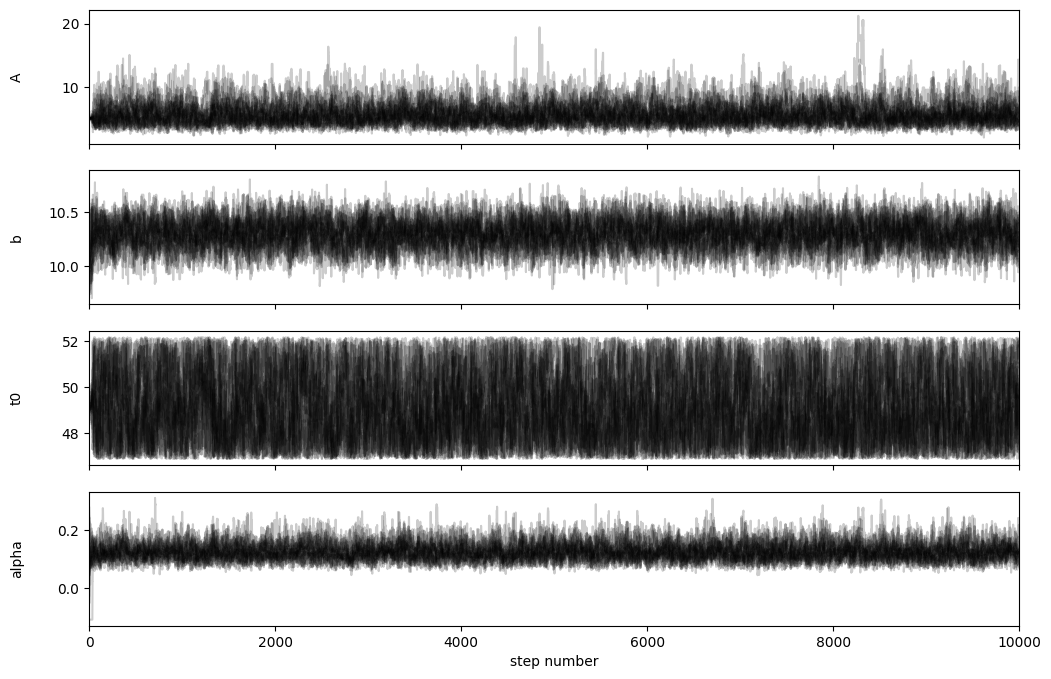

In [10]:
fig, axes = plt.subplots(4, figsize=(12, 8), sharex=True)
samples = sampler.get_chain()
labels = ["A","b","t0","alpha"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.2)
    ax.set_ylabel(labels[i])
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.07, 0.5)

axes[-1].set_xlabel("step number");

Burn-in and thin the chain, using autocorrelation length

In [11]:
tau = sampler.get_autocorr_time()
print(tau)

[68.68166038 55.63751298 70.38287688 61.65652607]


In [12]:
flat_samples = sampler.get_chain(discard=2*int(max(tau)), thin=int(max(tau)), flat=True)
print(flat_samples.shape)

(2800, 4)


### Corner plots

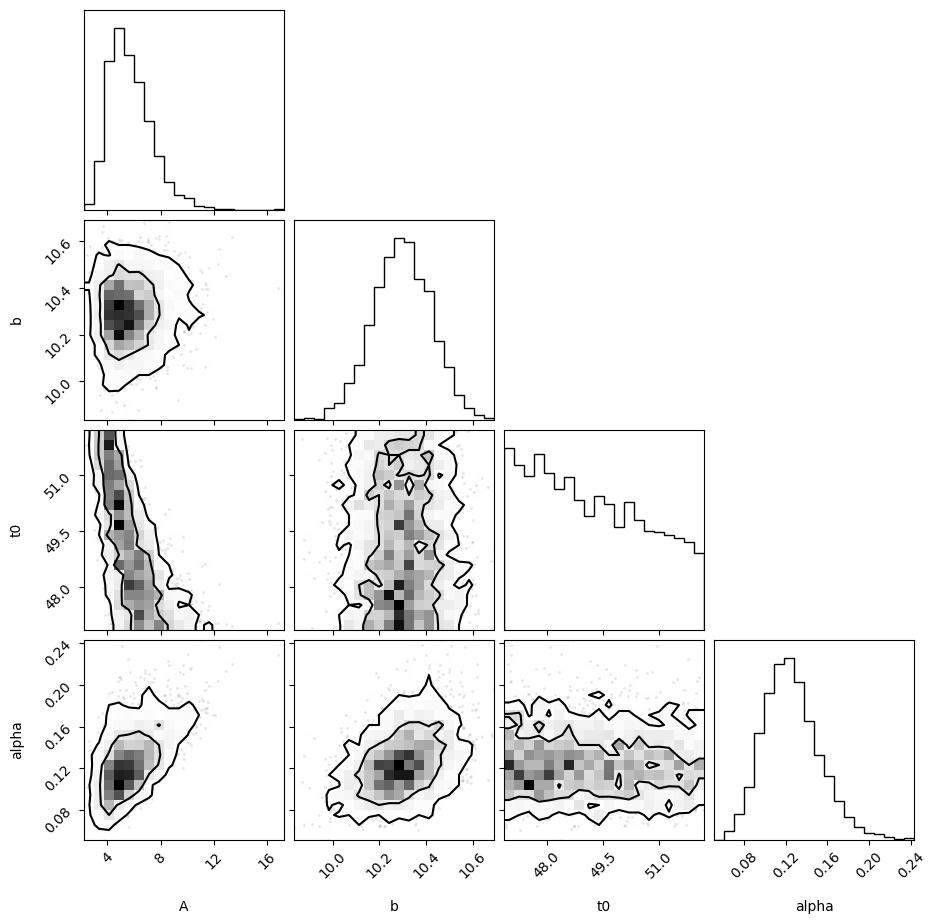

In [13]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, levels=[0.68,0.95]
);

Choose $100$ samples randomly and plot the model

In [14]:
nsamples = 100
chosen_samples= flat_samples[np.random.choice(len(flat_samples),size=nsamples)]
print(chosen_samples.shape)

(100, 4)


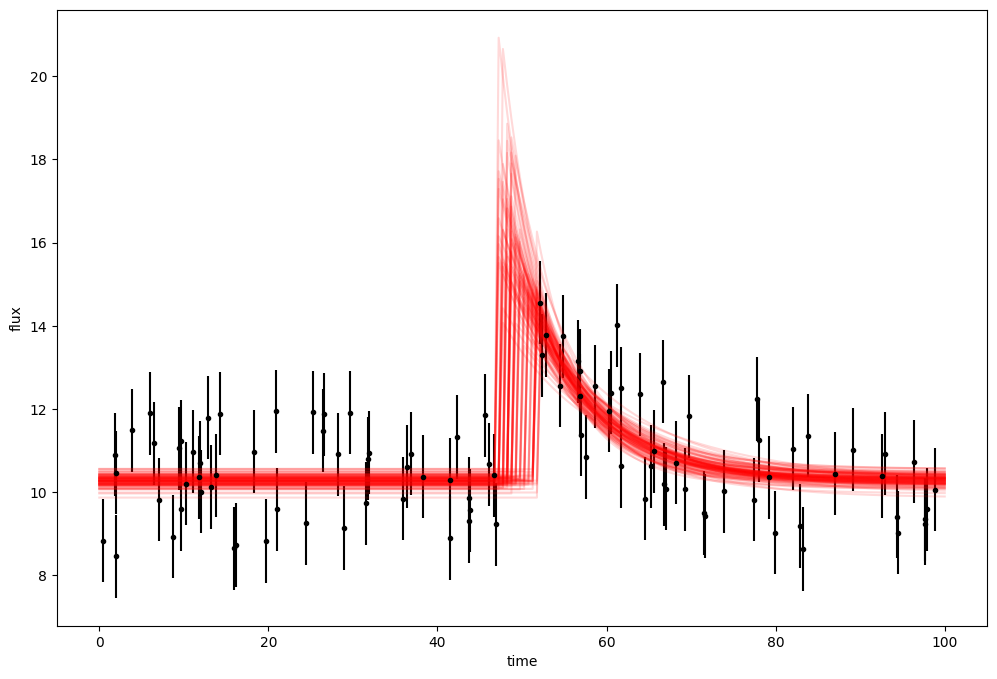

In [15]:
tgrid=np.linspace(0,100,200)

plt.figure(figsize=(12,8))
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)

for i in range(nsamples):
    plt.plot(tgrid, burst_model(tgrid, chosen_samples[i,:]), 'red', alpha = 0.15)
plt.xlabel("time")
plt.ylabel("flux")

plt.show()

Median and quantiles

In [16]:
for i,l in enumerate(labels):
    low, med, up = np.percentile(flat_samples[:,i],[5,50,95]) 
    print(l+"   "+str(med)+" +"+str(up-med)+" -"+str(med-low))

A   5.501542765340517 +3.253220583890821 -1.8502710732677277
b   10.296957336401851 +0.20169277048849032 -0.21069087669113706
t0   49.00233388743111 +2.7734584235743327 -1.9482752191434756
alpha   0.12292508977895453 +0.050927434418514606 -0.037273562428239204
